In [208]:
import pandas as pd
import pyspark as ps
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [1]:
spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("Spark Session Intro") \
            .getOrCreate()
sc = spark.sparkContext

In [30]:
f_tweets_json = spark.read.json('../spark/french_tweets.json')

In [31]:
f_tweets_json.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |

In [34]:
f_tweets_json.createOrReplaceTempView('tweets')

In [85]:
type(f_tweets_json)

pyspark.sql.dataframe.DataFrame

In [94]:
query = '''
--select entities.hashtags, user.id, user.friends_count, user.followers_count, user.following, user. follow_request_sent, user.created_at, possibly_sensitive
--select entities.hashtags, created_at, in_reply_to_screen_name, in_reply_to_status_id, in_reply_to_user_id
--select id as tweet_id, user.id as user_id, user.created_at, quoted_status.favorite_count, quoted_status.retweet_count, quoted_status.retweeted, quoted_status.favorited
--create table top_screen_name as
select in_reply_to_screen_name, in_reply_to_user_id, count(distinct user.id)
from tweets
where in_reply_to_screen_name is not null
group by 1, 2
order by 3 desc
limit 20;
'''

top_screen_name = spark.sql(query)


In [95]:
spark.sql(query).show()

+-----------------------+-------------------+-------------------------------+
|in_reply_to_screen_name|in_reply_to_user_id|count(DISTINCT user.id AS `id`)|
+-----------------------+-------------------+-------------------------------+
|         EmmanuelMacron|         1976143068|                            245|
|                   TPMP|          832766641|                            173|
|           MLP_officiel|          217749896|                            131|
|                  BFMTV|          133663801|                            128|
|           Cyrilhanouna|          378632690|                            102|
|           dupontaignan|           38170599|                             99|
|              Qofficiel| 743432061088899073|                             49|
|                 GG_RMC|          114512948|                             47|
|               THEDAMSO|          529836126|                             47|
|        Marion_M_Le_Pen|          520449734|                   

In [96]:
top_screen_name_df = top_screen_name.select("*").toPandas()

In [97]:
top_screen_name_df

,in_reply_to_screen_name,in_reply_to_user_id,count(DISTINCT user.id AS `id`)
0,EmmanuelMacron,1976143068,245
1,TPMP,832766641,173
2,MLP_officiel,217749896,131
3,BFMTV,133663801,128
4,Cyrilhanouna,378632690,102
5,dupontaignan,38170599,99
6,Qofficiel,743432061088899073,49
7,THEDAMSO,529836126,47
8,GG_RMC,114512948,47
9,Marion_M_Le_Pen,520449734,43


In [104]:
spark.sql('drop view if exists top_screen_name;')
q2 = '''
create temp view top_screen_name as
select in_reply_to_screen_name, in_reply_to_user_id, count(distinct user.id) as reply_count
from tweets
where in_reply_to_screen_name is not null
group by 1, 2
order by 3 desc
limit 20;
'''
spark.sql(q2)
q3 = '''
select * from top_screen_name;
'''
spark.sql(q3).show()

+-----------------------+-------------------+-----------+
|in_reply_to_screen_name|in_reply_to_user_id|reply_count|
+-----------------------+-------------------+-----------+
|         EmmanuelMacron|         1976143068|        245|
|                   TPMP|          832766641|        173|
|           MLP_officiel|          217749896|        131|
|                  BFMTV|          133663801|        128|
|           Cyrilhanouna|          378632690|        102|
|           dupontaignan|           38170599|         99|
|              Qofficiel| 743432061088899073|         49|
|                 GG_RMC|          114512948|         47|
|               THEDAMSO|          529836126|         47|
|        Marion_M_Le_Pen|          520449734|         43|
|              jmaphatie|          369914677|         41|
|              Le_Figaro|            8350912|         39|
|                   libe|           68440549|         38|
|               leLab_E1|          376812938|         37|
|            J

In [101]:
q4 = '''
select 
    in_reply_to_screen_name, 
    in_reply_to_user_id, 
    reply_count, 
    tweets
from top_screen_name
left join tweets 
    on tweets.user.id = top_screen_name.in_reply_to_user_id
'''
spark.sql(q4)



DataFrame[]

In [133]:
#spark.sql('drop view top_acc_replies;')
q5 = '''
create temp view top_acc_replies as
select in_reply_to_screen_name, user.id, user.name, user.created_at as user_creation_date, created_at as tweet_date, id as tweet_id, place.name, place.country
from tweets
where in_reply_to_screen_name in (select in_reply_to_screen_name from top_screen_name)
order by 1 desc;
'''
spark.sql(q5)
replies = spark.sql('select * from top_acc_replies')
replies.show()

+-----------------------+------------------+--------------------+--------------------+--------------------+------------------+--------------+-------+
|in_reply_to_screen_name|                id|                name|  user_creation_date|          tweet_date|          tweet_id|          name|country|
+-----------------------+------------------+--------------------+--------------------+--------------------+------------------+--------------+-------+
|                   libe|        2354982361|    le sac de talent|Fri Feb 21 15:39:...|Fri Apr 28 07:29:...|857859214059991040|       Quévert| France|
|                   libe|         178630919|annette levy willard|Sun Aug 15 07:29:...|Fri Apr 28 06:44:...|857847995513155586|         Paris| France|
|                   libe|786567002345185280|           VIQUESNEL|Thu Oct 13 13:59:...|Thu Apr 27 10:17:...|857539118527598593|      Bordeaux| France|
|                   libe|         493446569|            CPasbien|Wed Feb 15 20:19:...|Thu Apr 27 07:

In [134]:
replies_df = replies.select("*").toPandas()

In [ ]:
replies_df['user_creation_dt'] = replies_df['user_creation_date'].apply(lambda x:pd.to_datetime(x))
replies_df['tweet_dt'] = replies_df['tweet_date'].apply(lambda x:pd.to_datetime(x))

In [175]:
replies_df.columns = ['in_reply_to_screen_name','reply_user_id','reply_user_name', 'user_creation_date','tweet_date','tweet_id','location_name', 'country', 'user_creation_dt','tweet_dt']

In [176]:
replies_df.head()

,in_reply_to_screen_name,reply_user_id,reply_user_name,user_creation_date,tweet_date,tweet_id,location_name,country,user_creation_dt,tweet_dt
0,libe,493446569,CPasbien,Wed Feb 15 20:19:08 +0000 2012,Wed Apr 26 15:25:23 +0000 2017,857254286539067392,Niort,France,2012-02-15 20:19:08+00:00,2017-04-26 15:25:23+00:00
1,libe,579091759,Rêv de Presse,Sun May 13 16:29:36 +0000 2012,Wed Apr 26 17:33:11 +0000 2017,857286446939598850,Angers,France,2012-05-13 16:29:36+00:00,2017-04-26 17:33:11+00:00
2,libe,462343380,Cynthia-ZD,Thu Jan 12 21:17:40 +0000 2012,Thu Apr 27 07:01:47 +0000 2017,857489939549827074,Noisy-le-Grand,France,2012-01-12 21:17:40+00:00,2017-04-27 07:01:47+00:00
3,libe,493446569,CPasbien,Wed Feb 15 20:19:08 +0000 2012,Thu Apr 27 07:37:32 +0000 2017,857498936780705792,Niort,France,2012-02-15 20:19:08+00:00,2017-04-27 07:37:32+00:00
4,libe,493446569,CPasbien,Wed Feb 15 20:19:08 +0000 2012,Thu Apr 27 07:47:56 +0000 2017,857501554739466241,Niort,France,2012-02-15 20:19:08+00:00,2017-04-27 07:47:56+00:00


In [177]:
gb_name = replies_df.groupby('in_reply_to_screen_name')

In [178]:
gb_name.agg({'user_creation_dt':[max, min], 'tweet_dt':[max, min]})

user_creation_dt                            \
                                              max                       min   
in_reply_to_screen_name                                                       
AudreyPulvar            2017-01-22 18:31:37+00:00 2008-01-04 15:59:27+00:00   
BFMTV                   2017-04-21 13:17:58+00:00 2009-06-29 05:32:38+00:00   
Cyrilhanouna            2017-04-27 20:05:23+00:00 2009-06-17 07:30:16+00:00   
EmmanuelMacron          2017-04-23 17:09:28+00:00 2009-01-06 19:43:19+00:00   
Europe1                 2017-02-07 04:37:46+00:00 2011-02-15 08:40:11+00:00   
GG_RMC                  2017-04-24 18:11:20+00:00 2009-04-08 18:25:22+00:00   
JJBourdin_RMC           2017-04-27 06:57:02+00:00 2010-06-27 18:54:35+00:00   
JLMelenchon             2017-03-23 10:53:37+00:00 2007-05-09 01:07:34+00:00   
Le_Figaro               2017-04-19 05:01:06+00:00 2009-06-15 15:24:16+00:00   
Limportant_fr           2017-03-29 02:56:02+00:00 2009-12-30 09:09:49+00:00   
MLP_officiel            2017-04-19 05:01:06+00:00 2008-02-09 22:12:01+00:00   
Marion_M_Le_Pen         2017-03-31 15:48:01+00:00 2009-06-07 18:56:45+00:00   
Qofficiel               2016-05-19 17:42:35+00:00 2009-09-19 13:45:10+00:00   
THEDAMSO                2017-01-15 14:09:23+00:00 2010-06-11 02:58:10+00:00   
TPMP                    2017-04-27 20:05:23+00:00 2009-03-14 23:48:46+00:00   
Valeurs                 2017-03-23 10:53:37+00:00 2009-10-19 14:42:35+00:00   
dupontaignan            2017-02-10 10:53:47+00:00 2008-01-04 15:59:27+00:00   
jmaphatie               2017-03-31 15:48:01+00:00 2009-07-22 14:40:34+00:00   
leLab_E1                2017-03-23 10:53:37+00:00 2009-04-14 12:49:08+00:00   
libe                    2017-03-23 10:53:37+00:00 2009-06-17 07:30:16+00:00   

                                         tweet_dt                            
                                              max                       min  
in_reply_to_screen_name                                                      
AudreyPulvar            2017-04-28 21:43:15+00:00 2017-04-26 21:43:04+00:00  
BFMTV                   2017-04-29 00:12:36+00:00 2017-04-26 14:46:38+00:00  
Cyrilhanouna            2017-04-28 23:46:10+00:00 2017-04-26 14:45:34+00:00  
EmmanuelMacron          2017-04-29 04:50:57+00:00 2017-04-26 13:31:07+00:00  
Europe1                 2017-04-28 18:42:41+00:00 2017-04-26 14:56:53+00:00  
GG_RMC                  2017-04-28 19:46:36+00:00 2017-04-26 13:31:40+00:00  
JJBourdin_RMC           2017-04-28 19:42:51+00:00 2017-04-26 17:52:31+00:00  
JLMelenchon             2017-04-28 22:18:25+00:00 2017-04-26 14:37:55+00:00  
Le_Figaro               2017-04-28 21:17:01+00:00 2017-04-26 14:36:29+00:00  
Limportant_fr           2017-04-29 04:50:35+00:00 2017-04-26 15:14:50+00:00  
MLP_officiel            2017-04-29 03:32:16+00:00 2017-04-26 13:33:25+00:00  
Marion_M_Le_Pen         2017-04-28 22:21:09+00:00 2017-04-26 14:36:10+00:00  
Qofficiel               2017-04-29 04:01:55+00:00 2017-04-26 17:13:43+00:00  
THEDAMSO                2017-04-29 03:03:55+00:00 2017-04-26 18:03:03+00:00  
TPMP                    2017-04-29 00:11:33+00:00 2017-04-26 14:54:28+00:00  
Valeurs                 2017-04-28 23:27:21+00:00 2017-04-26 15:47:55+00:00  
dupontaignan            2017-04-29 04:39:28+00:00 2017-04-28 11:06:16+00:00  
jmaphatie               2017-04-29 03:49:27+00:00 2017-04-26 13:35:19+00:00  
leLab_E1                2017-04-29 04:26:25+00:00 2017-04-26 15:13:38+00:00  
libe                    2017-04-28 22:35:54+00:00 2017-04-26 15:25:23+00:00

In [181]:
city_counts = replies_df['location_name'].value_counts()

In [199]:
city_ct = city_counts.reset_index()

In [201]:
city_ct.columns = ['city', 'count']

In [202]:
city_ct.head()

,city,count
0,Paris,293
1,Toulouse,75
2,Aix-en-Provence,54
3,Nantes,50
4,Lognes,48


<AxesSubplot:xlabel='city'>

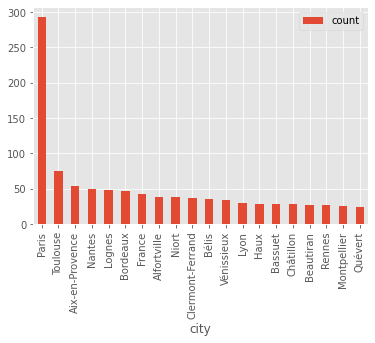

In [218]:
city_ct.iloc[:20,:].plot.bar('city', 'count');

In [221]:
city_ct.iloc[:20]

,city,count
0,Paris,293
1,Toulouse,75
2,Aix-en-Provence,54
3,Nantes,50
4,Lognes,48
5,Bordeaux,47
6,France,42
7,Alfortville,38
8,Niort,38
9,Clermont-Ferrand,37


In [222]:
macron = replies_df[replies_df['in_reply_to_screen_name'] == 'EmmanuelMacron']

(array([ 64.,  60.,  82.,  36.,  20.,   2.,  15.,  13.,  93., 144., 107.,
         67., 103., 264., 298., 161.,  13.,   6.,  17.,  88., 158., 114.,
         72., 100., 173., 207., 123.,  41.,   1.,  16.]),
 array([17282.56327546, 17282.65123457, 17282.73919367, 17282.82715278,
        17282.91511188, 17283.00307099, 17283.09103009, 17283.1789892 ,
        17283.2669483 , 17283.35490741, 17283.44286651, 17283.53082562,
        17283.61878472, 17283.70674383, 17283.79470293, 17283.88266204,
        17283.97062114, 17284.05858025, 17284.14653935, 17284.23449846,
        17284.32245756, 17284.41041667, 17284.49837577, 17284.58633488,
        17284.67429398, 17284.76225309, 17284.85021219, 17284.9381713 ,
        17285.0261304 , 17285.11408951, 17285.20204861]),
 <BarContainer object of 30 artists>)

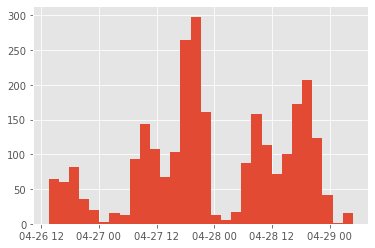

In [226]:
plt.hist(replies_df['tweet_dt'], bins = 30)

In [ ]:
user.friends_count, user.statuses_count,